<a href="https://colab.research.google.com/github/FranciscoFoz/Bootcamp-Alura-Data-Science-Aplicado-a-Financas/blob/main/Notebooks/Notebook_2_Desenvolvimento_do_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color= MediumSpringGreen		size = 6> Projeto Módulo 6 - Data Science aplicado a Finanças </font>

 # <font color= MediumSpringGreen		size = 5> Modelo de machine learning na aprovação de crédito financeiro </font>

Elaborado por [Francisco Foz](https://www.linkedin.com/in/francisco-tadeu-foz/)

Notebook 2

## <font color= MediumSpringGreen> Introdução

Olá! 

Este é o segundo notebook do projeto de [Data Science Aplicado a Finanças](https://github.com/FranciscoFoz/Bootcamp-Alura-Data-Science-Aplicado-a-Financas).

Você poderá encontrar o primeiro [aqui](https://github.com/FranciscoFoz/Bootcamp-Alura-Data-Science-Aplicado-a-Financas/blob/main/Notebooks/Notebook_1_Limpeza_transformacao_exploracao_dados.ipynb).

No primeiro foi realizado a limpeza, transformação e exploração dos dados.

Neste notebook o foco será o desenvolvimento do modelo de ML para a previsão de aprovação de crédito na aplicação. 

### <font color= MediumSpringGreen> Bibliotecas utilizadas em todo o projeto


Requirements


*   pandas==1.3.5
*   numpy==1.21.5
*   matplotlib==3.4.2
*   seaborn==0.11.2
*   sklearn==0.23.2
*   imbalanced-learn==0.7.0
*   scipy==1.4.1
*   six==1.16.0
*   lazypredict==0.2.7
*   skopt==0.8.1


Importarei as bibliotecas necessárias, configuradas no "requirements.txt" do projeto.

Devido outra versão do matplotlib, será necessário restartar o ambiente após a desisntalação da versão pré instalada no colab.

In [5]:
!pip install wget
import wget

In [6]:
wget.download('https://github.com/FranciscoFoz/Bootcamp-Alura-Data-Science-Aplicado-a-Financas/raw/main/requirements.txt', 'requirements.txt')

'requirements.txt'

In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix, roc_curve, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from scipy import stats

import six
import sys
sys.modules['sklearn.externals.six'] = six

import lazypredict
from lazypredict.Supervised import LazyClassifier, LazyRegressor

from skopt import BayesSearchCV

from joblib import dump


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## <font color= MediumSpringGreen> Importação das funções

Importarei o notebook com todas as funções necessárias para o projeto.

In [6]:
wget.download('https://raw.githubusercontent.com/FranciscoFoz/Bootcamp-Alura-Data-Science-Aplicado-a-Financas/main/Notebooks/funcoes.py', 'funcoes.py')

'funcoes.py'

In [7]:
import funcoes as f

## <font color= MediumSpringGreen> Importação de dados

Os dados importados serão os que foram trabalhados no 1º notebook. Localizado  na pasta "Datasets" no [repositório](https://github.com/FranciscoFoz/Bootcamp-Alura-Data-Science-Aplicado-a-Financas) deste projeto.

A partir disso, realizei a importação diretamente para o notebook.

In [8]:
df_registro_clientes_targets_sem_outliers = pd.read_csv('https://github.com/FranciscoFoz/Bootcamp-Alura-Data-Science-Aplicado-a-Financas/blob/main/Datasets/df_registro_clientes_targets_sem_outliers.csv?raw=true')


In [9]:
df_registro_clientes_targets_sem_outliers

,ID_Cliente,Idade,Qtd_Filhos,Rendimento_Anual,Anos_empregado,Tamanho_Familia,Tem_Carro,Tem_Casa_Propria,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Ocupacao,Mau
0,5008804,33.00,0.00,315000.00,12.40,2.00,1,1,1,0,0,Empregado,Ensino superior,Uniao estavel,Alugado,Outros,0
1,5008805,33.00,0.00,315000.00,12.40,2.00,1,1,1,0,0,Empregado,Ensino superior,Uniao estavel,Alugado,Outros,0
2,5008806,59.00,0.00,112500.00,3.10,2.00,1,1,0,0,0,Empregado,Ensino medio,Casado,Casa propria,Seguranca,0
3,5008810,52.00,0.00,270000.00,8.40,1.00,0,1,0,1,1,Associado comercial,Ensino medio,Solteiro,Casa propria,Venda,0
4,5008811,52.00,0.00,270000.00,8.40,1.00,0,1,0,1,1,Associado comercial,Ensino medio,Solteiro,Casa propria,Venda,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23414,5149729,52.00,0.00,90000.00,4.70,2.00,1,1,0,0,0,Empregado,Ensino medio,Casado,Casa propria,Outros,1
23415,5149775,44.00,0.00,130500.00,15.00,2.00,1,1,0,1,0,Empregado,Ensino medio,Casado,Casa propria,Construcao Civil,1
23416,5149834,34.00,0.00,157500.00,3.60,2.00,0,1,0,1,1,Associado comercial,Ensino superior,Casado,Casa propria,Medicina,1
23417,5149838,34.00,0.00,157500.00,3.60,2.00,0,1,0,1,1,Pensionista,Ensino superior,Casado,Casa propria,Medicina,1


## <font color= MediumSpringGreen> Configurações iniciais

### <font color= MediumSpringGreen> Definindo colunas de variáveis quantitativas e categóricas

In [10]:
colunas_quantitativas = ['Idade',
                         'Qtd_Filhos',
                         'Rendimento_Anual',
                         'Anos_empregado',
                         'Tamanho_Familia'
                         ]

colunas_categoricas = ['Tem_Carro',
                       'Tem_Casa_Propria',
                       'Categoria_de_renda',
                       'Grau_Escolaridade',
                       'Estado_Civil',
                       'Moradia',
                       'Tem_telefone_trabalho',
                       'Tem_telefone_fixo',
                       'Tem_email',
                       'Ocupacao'
                       ]

### <font color= MediumSpringGreen> Definindo SEED do projeto

In [11]:
SEED = np.random.seed(1561651)

## <font color= MediumSpringGreen> Escolhendo os melhores modelos

In [14]:
pipeline = Pipeline([('Transformador', f.Transformador(colunas_quantitativas, colunas_categoricas)),
                     ('sampling', SMOTE(random_state=SEED))])
f.escolhe_modelo(df_registro_clientes_targets_sem_outliers,SEED)

100%|██████████| 30/30 [01:22<00:00,  2.74s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.98,0.60,0.60,0.97,3.39
BaggingClassifier,0.98,0.60,0.60,0.97,0.86
ExtraTreeClassifier,0.97,0.60,0.60,0.97,0.09
DecisionTreeClassifier,0.97,0.60,0.60,0.97,0.19
ExtraTreesClassifier,0.98,0.59,0.59,0.97,1.75
LabelPropagation,0.97,0.59,0.59,0.97,16.01
LabelSpreading,0.97,0.59,0.59,0.97,32.80
NearestCentroid,0.55,0.56,0.56,0.69,0.12
LGBMClassifier,0.98,0.54,0.54,0.97,0.42


Com os melhores modelos testados, farei os primeiros testes com os 4 primeiros: RandomForestClassifier, BaggingClassifier, ExtraTreeClassifier e DecisionTreeClassifier além de realizar o comparativo com o DummyClassifier.

## <font color= MediumSpringGreen> Teste dos modelos

Dentre os testes dos modelos utilizarei a métrica de AUC, que é a área sob a curva ROC. 

A curva ROC é uma medida para se testar o quanto o modelo está com um índice de revocação e precisão. Quanto ele está conseguindo distinguir corretamente entre duas classificações.

* Precisão é a medida da Taxa de falso positivo, que é  VP / VP + FP.
  Dentre todas as classificações que o modelo prediz que é verdadeiro, o quanto são verdeiros. 

* Revocação é o a medida da Taxa de verdadeiro positivo, que é: VP / VP + FN;
  
  Dentre todas as classificações que o modelo prediz que é verdadeiro, o quanto ele tbm erra ao predizer o que é negativo.






Utilizarei também medida do KS (teste Kolmogorov-Smirnov) que indicará o quanto o modelo está conseguindo diferenciar as duas amostras preditas, caso tenha um avalor superior a 30% da media estatística, ela está diferenciando. 

Visualizarei também com matriz de confusão para entender dentre os valores preditos e reais, o quanto está fluindo o modelo. 
Analisando da perspectiva que é mais importante não disponibilizarmos crédito a maus pagadores.

Ao final analisarei com a tabela da classificação das medidas de precisaão revocação (recall) e f1-score (que é a média harmônica entre as duas).

## <font color= MediumSpringGreen>  DummyClassifier

AUC 0.5


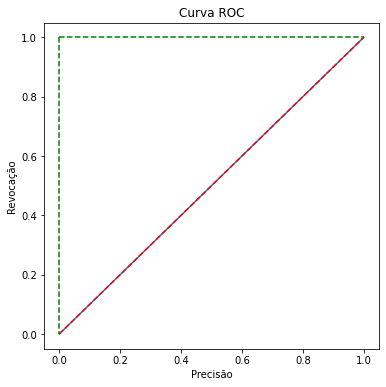

----------------------------------------------------------------------------------------------------
KS Ks_2sampResult(statistic=0.0, pvalue=1.0)
----------------------------------------------------------------------------------------------------


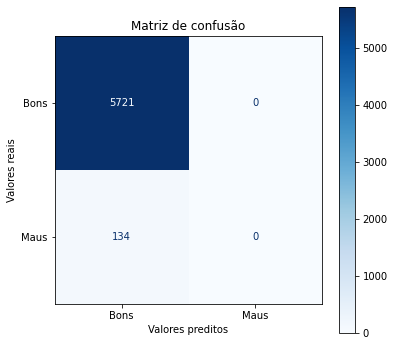

----------------------------------------------------------------------------------------------------

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5721
           1       0.00      0.00      0.00       134

    accuracy                           0.98      5855
   macro avg       0.49      0.50      0.49      5855
weighted avg       0.95      0.98      0.97      5855



In [81]:
pipeline = Pipeline([('Transformador', f.Transformador(colunas_quantitativas, colunas_categoricas)),
                     ('sampling', SMOTE(random_state=SEED)),
                     ('Modelo', DummyClassifier(random_state=SEED,strategy='prior'))])   
f.roda_modelo(pipeline, df_registro_clientes_targets_sem_outliers,SEED)


In [82]:
df_metricas_DummyClassifier = f.metricas_do_modelo(pipeline,'DummyClassifier', df_registro_clientes_targets_sem_outliers,SEED)
df_metricas_DummyClassifier

,AUC,F1-score_0,F1-score_1,Acurácia
DummyClassifier,0.50,0.99,0.00,0.98


Como já esperado, o Dummy performou com o padrão de 0.5.

## <font color= MediumSpringGreen>  ExtraTreeClassifier

AUC 0.7336508334050776


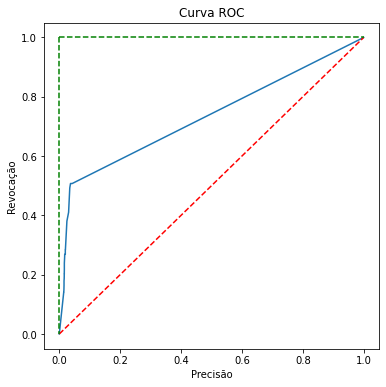

----------------------------------------------------------------------------------------------------
KS Ks_2sampResult(statistic=0.940734415029889, pvalue=0.0)
----------------------------------------------------------------------------------------------------


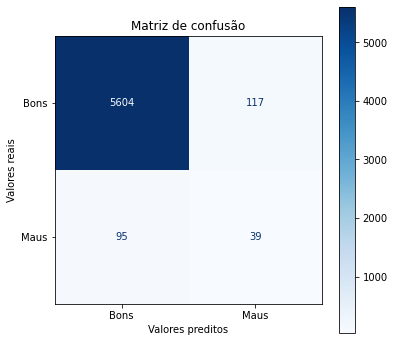

----------------------------------------------------------------------------------------------------

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5721
           1       0.25      0.29      0.27       134

    accuracy                           0.96      5855
   macro avg       0.62      0.64      0.63      5855
weighted avg       0.97      0.96      0.97      5855



In [83]:
pipeline = Pipeline([('Transformador', f.Transformador(colunas_quantitativas, colunas_categoricas)),
                     ('sampling', SMOTE(random_state=1)),
                     ('Modelo', ExtraTreeClassifier(random_state=SEED))])   
f.roda_modelo(pipeline, df_registro_clientes_targets_sem_outliers,SEED)


In [84]:
df_metricas_ExtratreeClassifier = f.metricas_do_modelo(pipeline,'ExtratreeClassifier', df_registro_clientes_targets_sem_outliers,SEED)
df_metricas_ExtratreeClassifier

,AUC,F1-score_0,F1-score_1,Acurácia
ExtratreeClassifier,0.70,0.98,0.26,0.96


O ExtratreeClassifier teve uma melhor performance, entretanto com um AUC não tão alto.

## <font color= MediumSpringGreen> DecisionTreeClassifier

AUC 0.6803808696423495


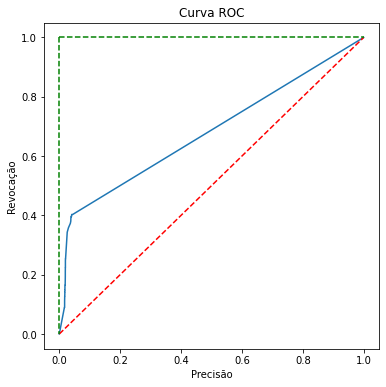

----------------------------------------------------------------------------------------------------
KS Ks_2sampResult(statistic=0.940734415029889, pvalue=0.0)
----------------------------------------------------------------------------------------------------


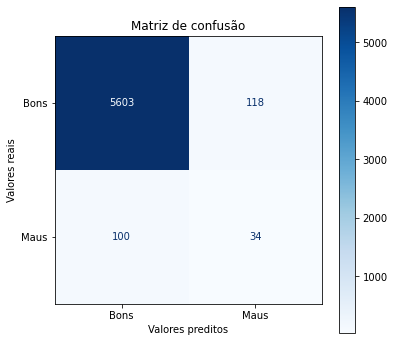

----------------------------------------------------------------------------------------------------

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5721
           1       0.22      0.25      0.24       134

    accuracy                           0.96      5855
   macro avg       0.60      0.62      0.61      5855
weighted avg       0.97      0.96      0.96      5855



In [85]:
pipeline = Pipeline([('Transformador', f.Transformador(colunas_quantitativas, colunas_categoricas)),
                     ('sampling', SMOTE(random_state=SEED)),
                     ('Modelo', DecisionTreeClassifier(random_state=SEED))])   
f.roda_modelo(pipeline, df_registro_clientes_targets_sem_outliers,SEED)


In [86]:
df_metricas_DecisionTreeClassifier = f.metricas_do_modelo(pipeline,'DecisionTreeClassifier', df_registro_clientes_targets_sem_outliers,SEED)
df_metricas_DecisionTreeClassifier

,AUC,F1-score_0,F1-score_1,Acurácia
DecisionTreeClassifier,0.72,0.98,0.31,0.97


O DecisionTree foi pior que o Extratree, tanto em AUC quanto nas métricas de F1-Score.

## <font color= MediumSpringGreen>  ExtraTreesClassifier

AUC 0.8054646797475654


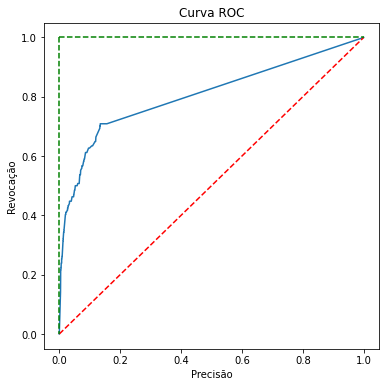

----------------------------------------------------------------------------------------------------
KS Ks_2sampResult(statistic=0.9665243381725022, pvalue=0.0)
----------------------------------------------------------------------------------------------------


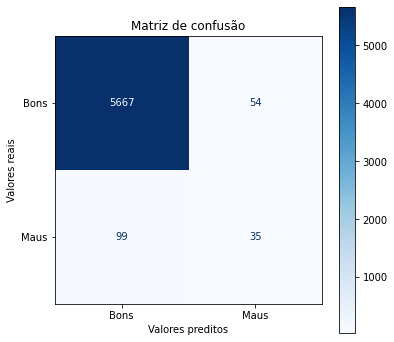

----------------------------------------------------------------------------------------------------

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5721
           1       0.39      0.26      0.31       134

    accuracy                           0.97      5855
   macro avg       0.69      0.63      0.65      5855
weighted avg       0.97      0.97      0.97      5855



In [87]:
pipeline = Pipeline([('Transformador', f.Transformador(colunas_quantitativas, colunas_categoricas)),
                     ('sampling', SMOTE(random_state=SEED)),
                     ('Modelo', ExtraTreesClassifier(random_state=SEED))])   
f.roda_modelo(pipeline, df_registro_clientes_targets_sem_outliers,SEED)

In [88]:
df_metricas_ExtraTreesClassifier = f.metricas_do_modelo(pipeline,'ExtraTreesClassifier', df_registro_clientes_targets_sem_outliers,SEED)
df_metricas_ExtraTreesClassifier

,AUC,F1-score_0,F1-score_1,Acurácia
ExtraTreesClassifier,0.78,0.99,0.33,0.97


O ExtratreesClassifier teve uma melhor performance geral e escolherei ele para ir para o a otimização dos parâmetros.

## <font color= MediumSpringGreen>  RandomForestClassifier

AUC 0.7514694487708287


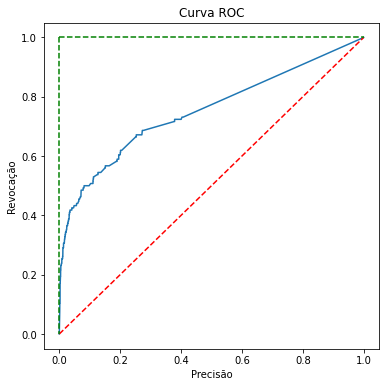

----------------------------------------------------------------------------------------------------
KS Ks_2sampResult(statistic=0.9699402220324509, pvalue=0.0)
----------------------------------------------------------------------------------------------------


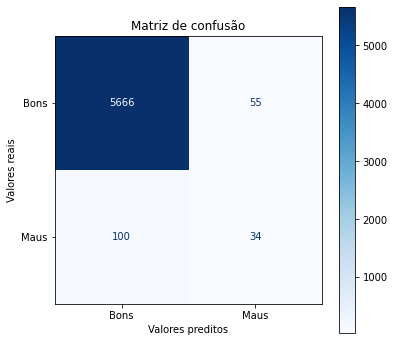

----------------------------------------------------------------------------------------------------

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5721
           1       0.38      0.25      0.30       134

    accuracy                           0.97      5855
   macro avg       0.68      0.62      0.65      5855
weighted avg       0.97      0.97      0.97      5855



In [89]:
pipeline = Pipeline([('Transformador', f.Transformador(colunas_quantitativas, colunas_categoricas)),
                     ('sampling', SMOTE(random_state=SEED)),
                     ('Modelo', RandomForestClassifier(random_state=SEED))])   
f.roda_modelo(pipeline, df_registro_clientes_targets_sem_outliers,SEED)

In [90]:
df_metricas_RandomForestClassifier = f.metricas_do_modelo(pipeline,'RandomForestClassifier', df_registro_clientes_targets_sem_outliers,634413)
df_metricas_RandomForestClassifier

,AUC,F1-score_0,F1-score_1,Acurácia
RandomForestClassifier,0.77,0.99,0.30,0.97


O RandomForest nfoi o que teve a segunda melhor métrica e por isso também escolherei ele para otimizar os parâmetros.

### <font color= MediumSpringGreen>  1ª Tabela comparativa dos modelos

In [91]:
lista_dos_DataFrames = [df_metricas_RandomForestClassifier,
                        df_metricas_ExtraTreesClassifier,
                        df_metricas_DecisionTreeClassifier,
                        df_metricas_ExtratreeClassifier,
                        df_metricas_DummyClassifier]

In [92]:
f.tabela_comparativa(lista_dos_DataFrames)

,AUC,F1-score_0,F1-score_1,Acurácia
ExtraTreesClassifier,0.78,0.99,0.33,0.97
RandomForestClassifier,0.77,0.99,0.30,0.97
DecisionTreeClassifier,0.72,0.98,0.31,0.97
ExtratreeClassifier,0.70,0.98,0.26,0.96
DummyClassifier,0.50,0.99,0.00,0.98


Podemos observar com esta tabela as principais métricas e as duas principais são o AUC e o F1-Score_1 (devido a não aprovar crédito para maus pagadores).

## <font color= MediumSpringGreen> Otimização dos parâmetros

Escolhi uma otimização de parâmetros Bayesiana, devido a sua escolha dos melhores valores de acordo com a maior probabilidade de métricas mais corretas.

## <font color= MediumSpringGreen> ExtratreesClassifier

In [94]:
params_ExtratreesClassifier = {'Modelo__max_depth': [None,2,4,6,8,10],
                               'Modelo__max_leaf_nodes': [None,2,4,6,8,10],
                               'Modelo__min_samples_leaf': [2,4,6],
                               'Modelo__min_samples_split': [2,4,6]}

In [ ]:
pipeline = Pipeline([('Transformador', f.Transformador(colunas_quantitativas, colunas_categoricas)),
                     ('sampling', SMOTE(random_state=SEED)),
                     ('Modelo', ExtraTreesClassifier(random_state=SEED))]) 
f.otimizar_param_bayesiano(pipeline,params_ExtratreesClassifier,df_registro_clientes_targets_sem_outliers)

OrderedDict([('Modelo__max_depth', None),
             ('Modelo__max_leaf_nodes', None),
             ('Modelo__min_samples_leaf', 2),
             ('Modelo__min_samples_split', 2)])

AUC 0.7474100394722767


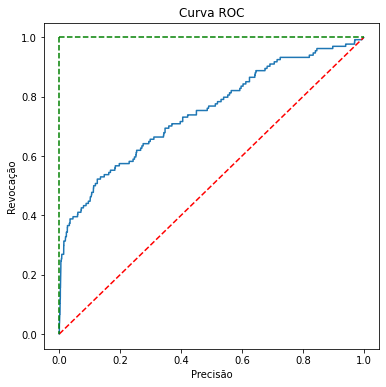

----------------------------------------------------------------------------------------------------
KS Ks_2sampResult(statistic=0.9111870196413322, pvalue=0.0)
----------------------------------------------------------------------------------------------------


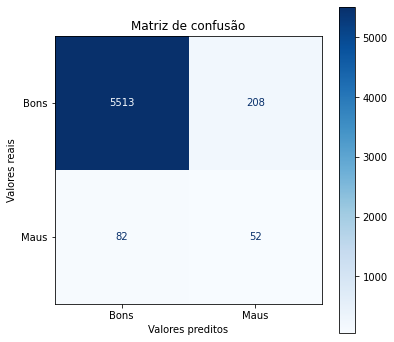

----------------------------------------------------------------------------------------------------

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5721
           1       0.20      0.39      0.26       134

    accuracy                           0.95      5855
   macro avg       0.59      0.68      0.62      5855
weighted avg       0.97      0.95      0.96      5855



In [117]:
pipeline = Pipeline([('Transformador', f.Transformador(colunas_quantitativas, colunas_categoricas)),
                     ('sampling', SMOTE(random_state=SEED)),
                     ('Modelo', ExtraTreesClassifier(random_state=SEED,min_samples_leaf=2,min_samples_split = 2))]) 
f.roda_modelo(pipeline, df_registro_clientes_targets_sem_outliers,SEED)

In [118]:
df_metricas_ExtraTreesClassifier_otimizado = f.metricas_do_modelo(pipeline,'ExtraTreesClassifier', df_registro_clientes_targets_sem_outliers,634413)
df_metricas_ExtraTreesClassifier_otimizado

,AUC,F1-score_0,F1-score_1,Acurácia
ExtraTreesClassifier,0.72,0.98,0.25,0.95


## <font color= MediumSpringGreen>  RandomForestClassifier

In [100]:
params_RandomForestClassifier = {'Modelo__n_estimators': [100,250,500,1000,2000]}

In [ ]:
pipeline = Pipeline([('Transformador', f.Transformador(colunas_quantitativas, colunas_categoricas)),
                     ('sampling', SMOTE(random_state=SEED)),
                     ('Modelo', (random_state=SEED))]) 
f.otimizar_param_bayesiano(pipeline,params_RandomForestClassifier,df_registro_clientes_targets_sem_outliers)

In [28]:
modelo_RandomForest_otimizado = RandomForestClassifier(random_state=SEED,n_estimators=1000)

AUC 0.8124708132123859


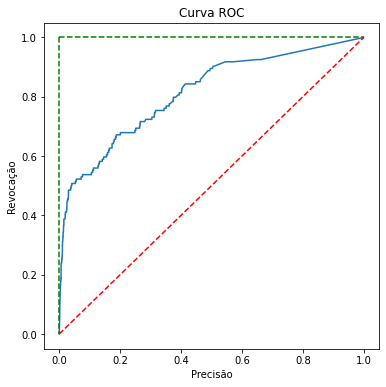

----------------------------------------------------------------------------------------------------
KS Ks_2sampResult(statistic=0.9649871904355252, pvalue=0.0)
----------------------------------------------------------------------------------------------------


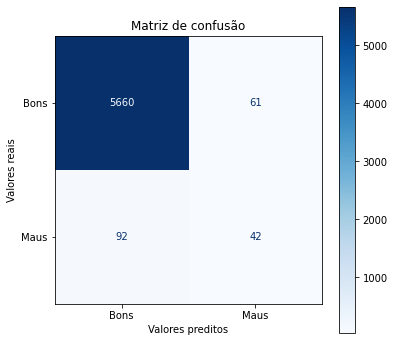

----------------------------------------------------------------------------------------------------

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5721
           1       0.41      0.31      0.35       134

    accuracy                           0.97      5855
   macro avg       0.70      0.65      0.67      5855
weighted avg       0.97      0.97      0.97      5855



In [99]:
pipeline = Pipeline([('Transformador', f.Transformador(colunas_quantitativas, colunas_categoricas)),
                     ('sampling', SMOTE(random_state=SEED)),
                     ('Modelo', modelo_RandomForest_otimizado)]) 
f.roda_modelo(pipeline, df_registro_clientes_targets_sem_outliers,SEED)

In [101]:
df_metricas_RandomForestClassifier_otimizado = f.metricas_do_modelo(pipeline,'RandomForestClassifier', df_registro_clientes_targets_sem_outliers,SEED)
df_metricas_RandomForestClassifier_otimizado

,AUC,F1-score_0,F1-score_1,Acurácia
RandomForestClassifier,0.80,0.99,0.31,0.97


### <font color= MediumSpringGreen> 2ª Tabela comparativa dos modelos

In [103]:
lista_dos_DataFrames = [df_metricas_ExtraTreesClassifier_otimizado,
                        df_metricas_RandomForestClassifier_otimizado]

In [104]:
f.tabela_comparativa(lista_dos_DataFrames)

,AUC,F1-score_0,F1-score_1,Acurácia
RandomForestClassifier,0.80,0.99,0.31,0.97
ExtraTreesClassifier,0.72,0.97,0.23,0.95


O RandomForest otimizado, teve os melhores valores de AUC e F1-Score.

Por isso, escolheirei ele para salvar e utiliza na aplicação.

## <font color= MediumSpringGreen> Salvando modelo

Salvarei o modelo completo com o pipeline.

In [105]:
pipeline = Pipeline([('Transformador', f.Transformador(colunas_quantitativas, colunas_categoricas)),
                     ('sampling', SMOTE(random_state=SEED)),
                     ('Modelo', modelo_RandomForest_otimizado)])

In [106]:
x = df_registro_clientes_targets_sem_outliers.drop(['ID_Cliente', 'Mau'], axis=1)
y = df_registro_clientes_targets_sem_outliers['Mau']

pipeline.fit(x, y)

Pipeline(steps=[('Transformador',
                 Transformador(colunas_categoricas=['Tem_Carro',
                                                    'Tem_Casa_Propria',
                                                    'Categoria_de_renda',
                                                    'Grau_Escolaridade',
                                                    'Estado_Civil', 'Moradia',
                                                    'Tem_telefone_trabalho',
                                                    'Tem_telefone_fixo',
                                                    'Tem_email', 'Ocupacao'],
                               colunas_quantitativas=['Idade', 'Qtd_Filhos',
                                                      'Rendimento_Anual',
                                                      'Anos_empregado',
                                                      'Tamanho_Familia'])),
                ('sampling', SMOTE()),
                ('Modelo', RandomFore

In [107]:
dump(modelo_RandomForest_otimizado, 'Credit_scoring_RandomForest_preditor.joblib')


['Credit_scoring_RandomForest_preditor.joblib']

## <font color= MediumSpringGreen> Salvando as features 

Salvarei os nomes das features necessárias para a aplicação.

In [108]:
features = x.columns
features

Index(['Idade', 'Qtd_Filhos', 'Rendimento_Anual', 'Anos_empregado',
       'Tamanho_Familia', 'Tem_Carro', 'Tem_Casa_Propria',
       'Tem_telefone_trabalho', 'Tem_telefone_fixo', 'Tem_email',
       'Categoria_de_renda', 'Grau_Escolaridade', 'Estado_Civil', 'Moradia',
       'Ocupacao'],
      dtype='object')

In [109]:
dump(features, 'features.joblib')


['features.joblib']

## <font color= MediumSpringGreen> Salvando a lista dos campos

Salvarei a lista dos campos necessários para a aplicação.

In [110]:
colunas_categoricas_nao_binarias = ['Categoria_de_renda',
                                    'Grau_Escolaridade',
                                    'Estado_Civil',
                                    'Moradia',
                                    'Ocupacao']

In [111]:
lista_campos = df_registro_clientes_targets_sem_outliers[colunas_categoricas_nao_binarias].apply(lambda x: x.unique(),axis=0)
lista_campos

Categoria_de_renda    [Empregado, Associado comercial, Pensionista, ...
Grau_Escolaridade     [Ensino superior, Ensino medio, Ensino superio...
Estado_Civil          [Uniao estavel, Casado, Solteiro, Separado, Vi...
Moradia               [Alugado, Casa propria, Habitacao publica, Mor...
Ocupacao              [Outros, Seguranca, Venda, Contabilidade, Cons...
dtype: object

In [112]:
dump(lista_campos, 'lista_campos.joblib')


['lista_campos.joblib']